# ECSE 551 Assignment 2

In [3]:
from google.colab import drive

import re
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from time import time
from google.colab import files 

# nltk libraries
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
from nltk import word_tokenize
from nltk.corpus import wordnet
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

# sklearn libraries
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Normalizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer    #TF-IDF
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction import text
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate

# models
from sklearn import tree
from sklearn.svm import SVC
from sklearn.svm import LinearSVC #SVM
from sklearn.naive_bayes import MultinomialNB #NB
from sklearn.linear_model import LogisticRegression #LR
from sklearn.neighbors import KNeighborsClassifier #KNN
from sklearn.neural_network import MLPClassifier #multi-layer perceptron
from sklearn.ensemble import RandomForestClassifier

# emsemble
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import StackingClassifier


# TSNE visualizer
from yellowbrick.text import TSNEVisualizer
from yellowbrick.text.freqdist import FreqDistVisualizer

drive.mount('/content/gdrive')

path = "./gdrive/MyDrive/ECSE_551_Assignment_2/Data/"

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


Mounted at /content/gdrive


## Loading Data

In [7]:
df_train = pd.read_csv(path + 'train.csv', encoding = 'ISO-8859-1')
df_train = df_train.sample(frac=1, random_state=0).reset_index(drop=True) #shuffle df_train

df_test = pd.read_csv(path + 'test.csv', encoding = 'ISO-8859-1')

In [8]:
df_train.head()

,body,subreddit
0,A couple things to consider. If your name on y...,Facebook
1,"Hello,\n\nIf one person had Viber installed on...",viber
2,I've been getting the same notification every ...,Instagram
3,unreal. so get this. I finally got a recovery ...,Facebook
4,Hi.\n\nSuddenly it happens that when somebody ...,viber


In [9]:
df_test.head()

,id,body
0,1,"firebase is included because of push iirc, but..."
1,2,change the forwarded messages preference to no...
2,3,Say if a conversation is like A wrote this and...
3,4,Perhaps try using a different gallery app? I s...
4,5,Lol why do you need a bot? Is it a hard thing ...


## Helper Methods for Output

In [10]:
def decode_output(pred):
  label_name_list = ['Telegram','Linkedin', 'Instagram', 'viber','Facebook']
  output = []
  for index in pred:
    output.append(label_name_list[index])
  return np.array(output)

def download_csv(pred):
  output = decode_output(pred)
  output_df = pd.DataFrame(output, columns = ['subreddit'])
  output_df.insert(0, 'id', output_df.index + 1)
  output_df.to_csv("submission.csv", index=None)
  files.download('submission.csv')

## Model

### Bernoulli Naive Bayes model

In [11]:
class Bernoulli_Naive_Bayes_Clf():

    def __init__(self):
        self.prior_prob = 0
        self.post_prob_x_pos_y_neg = []
        self.post_prob_x_neg_y_neg = []
        self.post_prob_x_pos_y_pos = []
        self.post_prob_x_neg_y_pos = []

    def fit(self, X_train, Y_train):

        m = X_train.shape[1]
        num_y_pos = np.count_nonzero(Y_train)
        num_y_neg = Y_train.shape[0] - num_y_pos

        self.prior_prob = num_y_pos/m   # prior probability for y
        
        # get posterior probabilities
        for i in range(m):
          count_x_pos_y_pos = 0
          count_x_pos_y_neg = 0
          for index, vect in enumerate(X_train):
            if(vect[i] != 0):
              if(Y_train[index] == 0):
                count_x_pos_y_neg = count_x_pos_y_neg + 1
              else:
                count_x_pos_y_pos = count_x_pos_y_pos + 1 
          prob_y_neg = (count_x_pos_y_neg+1) / (num_y_neg+2)
          prob_y_pos = (count_x_pos_y_pos+1) / (num_y_pos+2)
          self.post_prob_x_pos_y_neg.append(prob_y_neg)
          self.post_prob_x_neg_y_neg.append(1 - prob_y_neg)
          self.post_prob_x_pos_y_pos.append(prob_y_pos)
          self.post_prob_x_neg_y_pos.append(1 - prob_y_pos)

    def __calc_likelihood(self, x_T):
          p_y_neg = 1 - self.prior_prob
          p_y_pos = self.prior_prob
          for index,bin in enumerate(x_T):
            if(bin == 0):
              p_y_pos = p_y_pos * self.post_prob_x_neg_y_pos[index]
              p_y_neg = p_y_neg * self.post_prob_x_neg_y_neg[index]
            else:
              p_y_pos = p_y_pos * self.post_prob_x_pos_y_pos[index]
              p_y_neg = p_y_neg * self.post_prob_x_pos_y_neg[index]
          return p_y_pos, p_y_neg

    def pred_binary(self, X_test):
        predicted = []
        
        for x in X_test:
          likelihood_pos, likelihood_neg = self.__calc_likelihood(x.T)

          if(np.log(likelihood_pos/likelihood_neg) > 0): # log-odds ratio
            predicted.append(1)
          else: 
            predicted.append(0)
        return predicted

    def get_class_prob(self, X_test):
        scores = []
        
        for x in X_test:
          likelihood_pos, likelihood_neg = self.__calc_likelihood(x.T)
          # higher log odds ratio, higher class probability
          scores.append(np.log(likelihood_pos) - np.log(likelihood_neg)) 
        return scores

In [12]:
class BNB_OVR_classifier():

  def __init__(self):
    self.model = Bernoulli_Naive_Bayes_Clf()

  def pred(self, X_train, y_train, X_test, get_X_train_pred = False):
    # Create one hot encodings of each class
    label_name_list = ['Telegram','Linkedin', 'Instagram', 'viber','Facebook']
    encoded_y_train_list = []
    for label_name in label_name_list:
      encoded_y_train_list.append([(int)(y == label_name) for y in y_train])

    # Get score lists for each class
    score_list_test = []
    if(get_X_train_pred): 
      score_list_train = []

    for encoded_y_train in encoded_y_train_list:
      self.model = Bernoulli_Naive_Bayes_Clf()
      self.model.fit(X_train, np.array(encoded_y_train))

      score_list_test.append(self.model.get_class_prob(X_test))

      if(get_X_train_pred): 
        score_list_train.append(self.model.get_class_prob(X_train))

    # Return final predictions
    index_array_test = np.argmax(np.array(score_list_test), axis=0)
    if(get_X_train_pred):
      index_array_train = np.argmax(np.array(score_list_train), axis=0)
      return index_array_test, index_array_train
  
    return index_array_test 

## Preprocessing

In [13]:
np_train = df_train.to_numpy()
np_test = df_test.to_numpy()

print('train data dimensions: ' + str(np_train.shape))
print('test data dimensions: ' + str(np_test.shape))

train data dimensions: (1749, 2)
test data dimensions: (698, 2)


In [14]:
X_train = np_train[:,0].tolist() #x
y_train = np_train[:,1] #y
X_test = np_test[:,1].tolist()

### Stem and Lemma Tokenizers

In [15]:
class StemTokenizer:
     def __init__(self):
       self.wn =PorterStemmer()
     def __call__(self, doc):
       return [self.wn.stem(t) for t in word_tokenize(doc) if t.isalpha()]

In [16]:
class LemmaTokenizer:
     def __init__(self):
       self.wnl = WordNetLemmatizer()
     def __call__(self, doc):
       return [self.wnl.lemmatize(t,pos ="n") for t in word_tokenize(doc) if t.isalpha()]

###Construct stop words

In [79]:
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

stemmed_stop_words=set()
lemmatized_stop_words=set()
english_stop_words=text.ENGLISH_STOP_WORDS
for word in english_stop_words:
    stemmed_stop_words.add(PorterStemmer().stem(word))
    lemmatized_stop_words.add(WordNetLemmatizer().lemmatize(word, pos = get_wordnet_pos(word)))

### Vectorizer

####TF-IDF vectorizer

In [80]:
vectorizer = TfidfVectorizer(max_features=3000,lowercase=True, ngram_range=(1,1), stop_words=text.ENGLISH_STOP_WORDS)

#### binary vectorizer

In [81]:
vectorizer = CountVectorizer(lowercase=True, ngram_range=(1,1), max_features=10000, stop_words=text.ENGLISH_STOP_WORDS)

### Testing Vectorize

In [82]:
vec_X_train = vectorizer.fit_transform(X_train)
vec_X_test = vectorizer.transform(X_test)

print(vectorizer.get_feature_names())
print(len(vectorizer.get_feature_names()))

['00', '000', '01', '02', '03', '039', '04', '053ccd86927a6a978856efdfcc6a528532a14fdf', '076whoivmds71', '08', '09', '0b', '0v1cyponzen61', '10', '100', '1000', '10000', '1000s', '100fps', '100hz', '100k', '100kb', '100s', '1023801277', '1050', '1050ti', '1070', '1080', '1081', '10am', '10k', '10m', '10th', '11', '110', '115k', '119', '11eb', '11pm', '12', '120', '12000kb', '121', '1234567890', '125200919', '127', '1284', '128k', '12th', '13', '1300', '132', '134', '13th', '14', '1427744841325289473', '1428439006581301252', '1428441477244506115', '1437132343626637317', '144fps', '144hz', '1485', '14h', '14th', '15', '150', '1500', '1507', '1582', '1589', '159096464162185', '15mins', '15sec', '15secs', '16', '1635439', '16gb', '17', '1736', '17629', '17m', '18', '183000765122339', '1870', '1872', '19', '1920x', '1930', '19442', '194b1320b', '1980s', '19k', '1h920ygx7w2ma', '1hc1n8jkxcp71', '1k', '1m', '1st', '1tb', '20', '200', '2000', '2003', '2005', '2009', '200k', '200million', '201

In [83]:
#optional normalize (Note TFIDF vectorizer already normalizes the data)
vec_X_train = Normalizer().transform(vec_X_train)
vec_X_test=Normalizer().transform(vec_X_test)

In [84]:
vec_X_train = vec_X_train.todense()
vec_X_test = vec_X_test.todense()

vec_X_train = np.asarray(vec_X_train)
vec_X_test = np.asarray(vec_X_test)

print("dimensions of vectorized X train: " + str(vec_X_train.shape))
print("dimensions of vectorized X test: " + str(vec_X_test.shape))

dimensions of vectorized X train: (1749, 8073)
dimensions of vectorized X test: (698, 8073)


### Process Labels

In [19]:
label_name_list = ['Telegram','Linkedin', 'Instagram', 'viber','Facebook']
encoded_y_train = np.array([label_name_list.index(label) for label in y_train])

### Visualizing Dataset

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

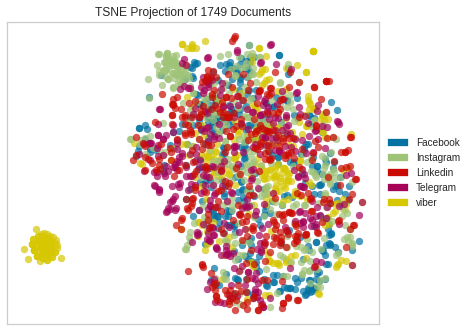

In [ ]:
vectorizer = CountVectorizer(max_features=3000)
vec_X_train = vectorizer.fit_transform(X_train)
features = vectorizer.get_feature_names()

# L2 Squared Euclidean Distance
tsnse = TSNEVisualizer(size = (600, 400)) 
tsnse.fit(vec_X_train, y_train)
tsnse.poof()

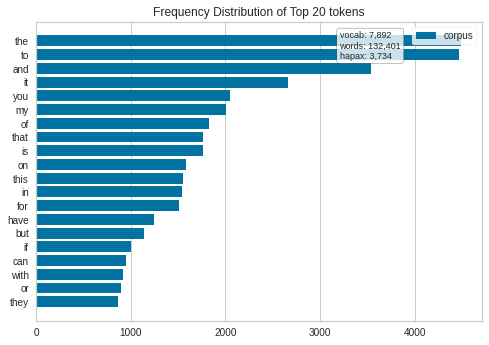

In [ ]:
vectorizer = CountVectorizer(max_features=9000)
vec_X_train = vectorizer.fit_transform(X_train)
features = vectorizer.get_feature_names()

visualizer = FreqDistVisualizer(features=features, n=20)
visualizer.fit(vec_X_train)
visualizer.poof()

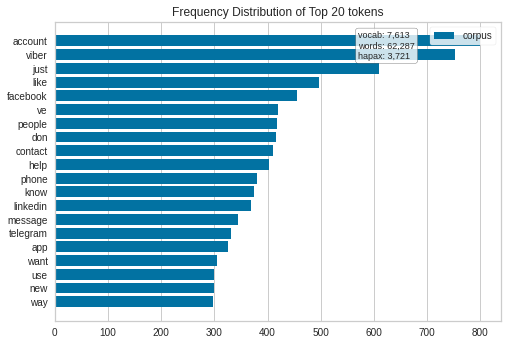

In [ ]:
vectorizer = CountVectorizer(max_features=9000, stop_words=text.ENGLISH_STOP_WORDS)
vec_X_train = vectorizer.fit_transform(X_train)
features = vectorizer.get_feature_names()

visualizer = FreqDistVisualizer(features=features, n=20)
visualizer.fit(vec_X_train)
visualizer.poof()

## Evaluation

In [86]:
def Accu_eval(ground_truth, predicted):
  return (ground_truth == predicted).mean()

### Cross Validation

In [87]:
def my_cross_validate(model, k = 10):

  kf=KFold(n_splits=k,shuffle=False) #k-fold validation

  accuracy_val = []
  accuracy_train = []

  index=kf.split(np_train)

  for train_index, test_index in index:
    score_list_val = []
    score_list_train = []

    X_train_CV, X_test_CV, y_train_CV = vec_X_train[train_index], vec_X_train[test_index], y_train[train_index]

    encoded_y_test_CV = encoded_y_train[test_index] 
    encoded_y_train_CV = encoded_y_train[train_index]

    pred_val, pred_train = model.pred(X_train_CV, y_train_CV, X_test_CV, True)

    acc_val = Accu_eval(pred_val, encoded_y_test_CV)
    acc_train = Accu_eval(pred_train, encoded_y_train_CV)

    accuracy_val.append(acc_val)
    accuracy_train.append(acc_train)

  CV_val_accuracy = np.array(accuracy_val).mean()
  CV_train_accuracy = np.array(accuracy_train).mean()

  print("cross validated training accuracy: " + str(CV_train_accuracy))
  print("cross validated validation accuracy: " + str(CV_val_accuracy))
  return CV_train_accuracy, CV_val_accuracy

### Experimentations on Ngram and Feature number

In [ ]:
ngram_range_list = [(1,1),(1,2),(1,3)]
feature_number_list = list(range(3000, 9000, 1000))

cv_ngram = []
for ngram_range in ngram_range_list:
  cv_acc = []
  for feature_number in feature_number_list:
    vectorizer = TfidfVectorizer(max_features=feature_number, stop_words = text.ENGLISH_STOP_WORDS,lowercase=True, ngram_range=ngram_range)
    vec_X_train = np.asarray(vectorizer.fit_transform(X_train).todense())
    model = BNB_OVR_classifier()
    CV_train_accuracy, CV_val_accuracy = my_cross_validate(model)
    cv_acc.append(CV_val_accuracy)
  cv_ngram.append(cv_acc.copy())

for ngram_acc in cv_ngram:
  plt.plot(feature_number_list, ngram_acc)
plt.legend(["unigram", "mixed unigram & bigram", "mixed unigram, bigram & trigram"])
plt.xlabel('number of features')
plt.ylabel('cross validation accuracy')
plt.show()

In [ ]:
def plot_ngram_num_features(model):
  ngram_range_list = [(1,1),(1,2),(1,3)]
  feature_number_list = list(range(3000, 9000, 1000))

  cv_ngram = []
  for ngram_range in ngram_range_list:
    cv_acc = []
    for feature_number in feature_number_list:
      vectorizer = TfidfVectorizer(max_features=feature_number, stop_words = text.ENGLISH_STOP_WORDS,lowercase=True, ngram_range=ngram_range)
      vec_X_train = np.asarray(vectorizer.fit_transform(X_train).todense())
      cv_results = cross_validate(model, vec_X_train, encoded_y_train, cv=10)
      cv_acc.append(cv_results['test_score'].mean())
    cv_ngram.append(cv_acc.copy())

  for ngram_acc in cv_ngram:
    plt.plot(feature_number_list, ngram_acc)
  plt.legend(["unigram", "mixed unigram & bigram", "mixed unigram, bigram & trigram"])
  plt.xlabel('number of features')
  plt.ylabel('cross validation accuracy')
  plt.show()

### BNB Best Model

In [ ]:
vectorizer = TfidfVectorizer(max_features=3000, stop_words = text.ENGLISH_STOP_WORDS,lowercase=True, ngram_range=(1,1), binary=True)
vec_X_train = np.asarray(vectorizer.fit_transform(X_train).todense())

clf = BNB_OVR_classifier()
start = time()
CV_train_accuracy, CV_val_accuracy = my_cross_validate(clf)
end = time()

In [ ]:
print("cross validated training accuracy: " + str(CV_train_accuracy))
print("cross validated validation accuracy: " + str(CV_val_accuracy))
print("cv run time:" + str(end - start))

cross validated training accuracy: 0.9554668118835844
cross validated validation accuracy: 0.8536453201970442
cv run time:305.90363335609436


## Investigations

In [ ]:
train_acc_results = [0.9554668118835844]
test_acc_results = [0.8536453201970442]
run_time = [305.90363335609436]

### Multinomial Naive Bayes

#### MNB Feature Size vs Ngram

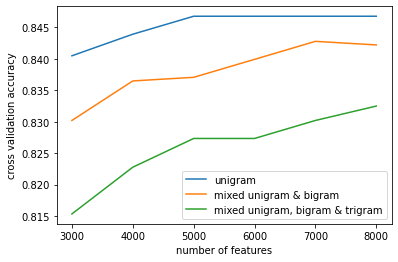

In [ ]:
plot_ngram_num_features(MultinomialNB())

#### MNB Hyperparameter Tuning

In [ ]:
bin_vectorizer = TfidfVectorizer(max_features=5000, stop_words = text.ENGLISH_STOP_WORDS,lowercase=True, ngram_range=(1,1), binary=True)
non_bin_vectorizer = TfidfVectorizer(max_features=5000, stop_words = text.ENGLISH_STOP_WORDS,lowercase=True, ngram_range=(1,1), binary=False)

bin_vec_X_train = np.asarray(bin_vectorizer.fit_transform(X_train).todense())
non_bin_vec_X_train = np.asarray(non_bin_vectorizer.fit_transform(X_train).todense())

Binary vectorizer:
max alpha:1.0 validation accuracy:0.8136091954022987
Non-Binary vectorizer
max alpha:0.9102981779915218 validation accuracy:0.8479178981937603


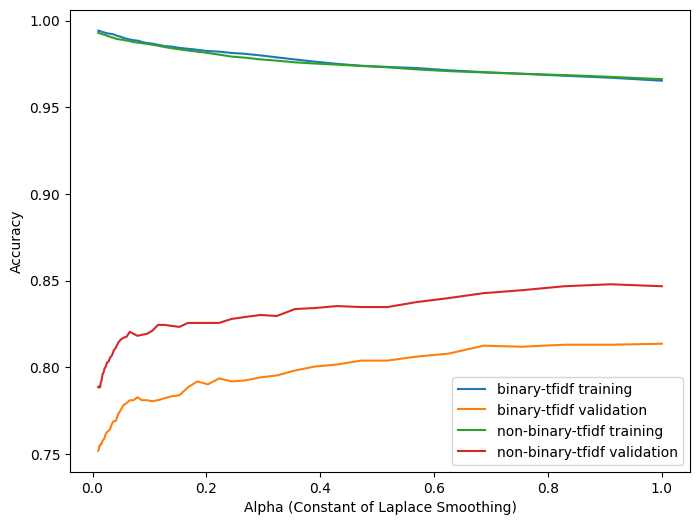

In [ ]:
plt.style.use('default')
plt.figure(figsize=(8,6))

alpha_list = np.logspace(-2,0)
tuned_parameters = [{'alpha':alpha_list}]

clf = MultinomialNB()

MNB_grid_binary = GridSearchCV(clf,tuned_parameters,cv = 10, return_train_score=True)
MNB_grid_binary.fit(bin_vec_X_train, encoded_y_train)
MNB_grid_non_binary = GridSearchCV(clf,tuned_parameters,cv = 10, return_train_score=True)
MNB_grid_non_binary.fit(non_bin_vec_X_train, encoded_y_train)

MNB_grid_train_scores_binary = MNB_grid_binary.cv_results_['mean_train_score']
MNB_grid_train_scores_non_binary = MNB_grid_non_binary.cv_results_['mean_train_score']
MNB_grid_test_scores_binary = MNB_grid_binary.cv_results_['mean_test_score']
MNB_grid_test_scores_non_binary = MNB_grid_non_binary.cv_results_['mean_test_score']

plt1 = plt.plot(alpha_list,MNB_grid_train_scores_binary)
plt2 = plt.plot(alpha_list,MNB_grid_test_scores_binary)

plt3 = plt.plot(alpha_list,MNB_grid_train_scores_non_binary)
plt4 = plt.plot(alpha_list,MNB_grid_test_scores_non_binary)

plt.xlabel('Alpha (Constant of Laplace Smoothing)')
plt.ylabel('Accuracy')
plt.legend(['binary-tfidf training','binary-tfidf validation','non-binary-tfidf training', 'non-binary-tfidf validation'])

print("Binary vectorizer:")
print('max alpha:' + str(alpha_list[np.argmax(MNB_grid_test_scores_binary)]) + " validation accuracy:" + str(MNB_grid_test_scores_binary.max()))
print("Non-Binary vectorizer")
print('max alpha:' + str(alpha_list[np.argmax(MNB_grid_test_scores_non_binary)]) + " validation accuracy:" + str(MNB_grid_test_scores_non_binary.max()))

#### MNB Best Model

In [ ]:
vectorizer = TfidfVectorizer(max_features=5000, stop_words = text.ENGLISH_STOP_WORDS,lowercase=True, ngram_range=(1,1), binary=False)
vec_X_train = np.asarray(vectorizer.fit_transform(X_train).todense())

clf = MultinomialNB(alpha=0.9102981779915218)
start = time()
cv_results = cross_validate(clf, vec_X_train, encoded_y_train, cv=10, return_train_score=True)
end = time()

print("cross validated training accuracy: " + str(cv_results['train_score'].mean()))
print("cross validated validation accuracy: " + str(cv_results['test_score'].mean()))

cross validated training accuracy: 0.9652499546197133
cross validated validation accuracy: 0.8467750410509032


In [ ]:
train_acc_results.append(cv_results['train_score'].mean())
test_acc_results.append(cv_results['test_score'].mean())
run_time.append(end-start)

### KNN

#### KNN Feature Size vs Ngram

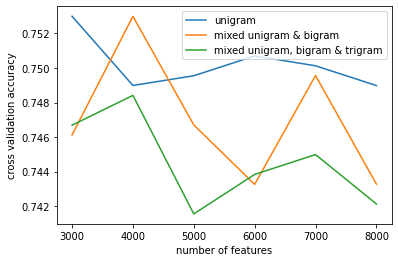

In [ ]:
plot_ngram_num_features(KNeighborsClassifier())

#### KNN Hyperparameter Tuning

In [ ]:
bin_vectorizer = TfidfVectorizer(max_features=4000, stop_words = text.ENGLISH_STOP_WORDS,lowercase=True, ngram_range=(1,2), binary=True)
non_bin_vectorizer = TfidfVectorizer(max_features=4000, stop_words = text.ENGLISH_STOP_WORDS,lowercase=True, ngram_range=(1,2), binary=False)

bin_vec_X_train = np.asarray(bin_vectorizer.fit_transform(X_train).todense())
non_bin_vec_X_train = np.asarray(non_bin_vectorizer.fit_transform(X_train).todense())

In [ ]:
plt.figure(figsize=(8,6))

k_list = range(5,115,5)
tuned_parameters = [{'n_neighbors':k_list}]

clf = KNeighborsClassifier()

KNN_grid_binary = GridSearchCV(clf,tuned_parameters,cv = 10, return_train_score=True)
KNN_grid_binary.fit(bin_vec_X_train, encoded_y_train)
KNN_grid_non_binary = GridSearchCV(clf,tuned_parameters,cv = 10, return_train_score=True)
KNN_grid_non_binary.fit(non_bin_vec_X_train, encoded_y_train)

KNN_grid_test_scores_binary = KNN_grid_binary.cv_results_['mean_test_score']
KNN_grid_test_scores_non_binary = KNN_grid_non_binary.cv_results_['mean_test_score']
KNN_grid_train_scores_binary = KNN_grid_binary.cv_results_['mean_train_score']
KNN_grid_train_scores_non_binary = KNN_grid_non_binary.cv_results_['mean_train_score']

plt1 = plt.plot(k_list,KNN_grid_train_scores_binary)
plt2 = plt.plot(k_list,KNN_grid_test_scores_binary)
plt3 = plt.plot(k_list,KNN_grid_train_scores_non_binary)
plt4 = plt.plot(k_list,KNN_grid_test_scores_non_binary)

plt.xlabel('number of neighbors')
plt.ylabel('Accuracy')
plt.legend(['binary-tfidf training','binary-tfidf validation','non-binary-tfidf training', 'non-binary-tfidf validation'])

print("Binary vectorizer:")
print('max k:' + str(k_list[np.argmax(KNN_grid_test_scores_binary)]) + " validation accuracy:" + str(KNN_grid_test_scores_binary.max()))
print("Non-Binary vectorizer")
print('max k:' + str(k_list[np.argmax(KNN_grid_test_scores_non_binary)]) + " validation accuracy:" + str(KNN_grid_test_scores_non_binary.max()))

#### KNN Best Model

In [ ]:
vectorizer = TfidfVectorizer(max_features=4000, stop_words = text.ENGLISH_STOP_WORDS,lowercase=True, ngram_range=(1,2), binary=False)
vec_X_train = np.asarray(vectorizer.fit_transform(X_train).todense())

clf = KNeighborsClassifier(n_neighbors=65)
start = time()
cv_results = cross_validate(clf, vec_X_train, encoded_y_train, cv=10, return_train_score=True)
end = time()

print("cross validated training accuracy: " + str(cv_results['train_score'].mean()))
print("cross validated validation accuracy: " + str(cv_results['test_score'].mean()))

cross validated training accuracy: 0.8392735927068836
cross validated validation accuracy: 0.8261937602627258


In [ ]:
train_acc_results.append(cv_results['train_score'].mean())
test_acc_results.append(cv_results['test_score'].mean())
run_time.append(end-start)

### Linear SVM

#### Linear SVM Feature Size vs Ngram

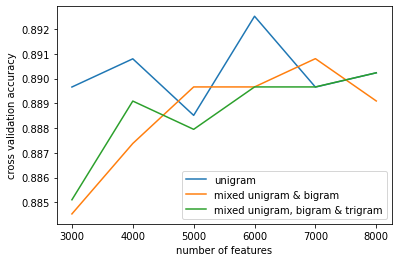

In [ ]:
plot_ngram_num_features(LinearSVC(random_state = 0))

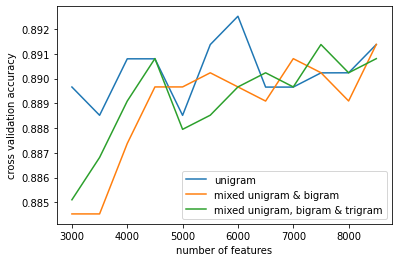

In [ ]:
for ngram_acc in cv_ngram:
  plt.plot(feature_number_list, ngram_acc)
plt.legend(["unigram", "mixed unigram & bigram", "mixed unigram, bigram & trigram"])
plt.xlabel('number of features')
plt.ylabel('cross validation accuracy')
plt.show()

#### Linear SVM Hyperparameter Tuning

In [ ]:
bin_vectorizer = TfidfVectorizer(max_features=6000, stop_words = text.ENGLISH_STOP_WORDS,lowercase=True, ngram_range=(1,1), binary=True)
non_bin_vectorizer = TfidfVectorizer(max_features=6000, stop_words = text.ENGLISH_STOP_WORDS,lowercase=True, ngram_range=(1,1), binary=False)

bin_vec_X_train = np.asarray(bin_vectorizer.fit_transform(X_train).todense())
non_bin_vec_X_train = np.asarray(non_bin_vectorizer.fit_transform(X_train).todense())

Binary vectorizer:
max C:0.517947467923121 validation accuracy:0.9005221674876847
Non-Binary vectorizer
max C:0.517947467923121 validation accuracy:0.8942364532019704


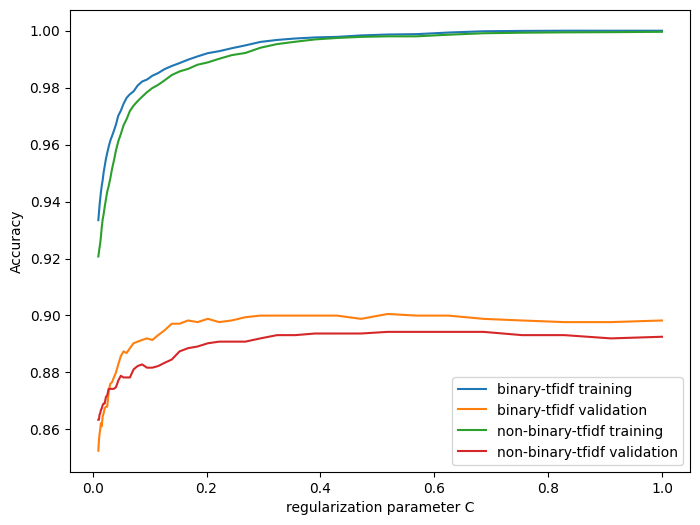

In [ ]:
plt.style.use('default')
plt.figure(figsize=(8,6))

C_list = np.logspace(-2,0)
tuned_parameters = [{'C':C_list}]

clf = LinearSVC(random_state = 0)

SVM_grid_binary = GridSearchCV(clf,tuned_parameters,cv = 10, return_train_score=True)
SVM_grid_binary.fit(bin_vec_X_train, encoded_y_train)
SVM_grid_non_binary = GridSearchCV(clf,tuned_parameters,cv = 10, return_train_score=True)
SVM_grid_non_binary.fit(non_bin_vec_X_train, encoded_y_train)

SVM_grid_test_scores_binary = SVM_grid_binary.cv_results_['mean_test_score']
SVM_grid_test_scores_non_binary = SVM_grid_non_binary.cv_results_['mean_test_score']
SVM_grid_train_scores_binary = SVM_grid_binary.cv_results_['mean_train_score']
SVM_grid_train_scores_non_binary = SVM_grid_non_binary.cv_results_['mean_train_score']

plt1 = plt.plot(C_list,SVM_grid_train_scores_binary)
plt2 = plt.plot(C_list,SVM_grid_test_scores_binary)

plt3 = plt.plot(C_list,SVM_grid_train_scores_non_binary)
plt4 = plt.plot(C_list,SVM_grid_test_scores_non_binary)

plt.xlabel('regularization parameter C')
plt.ylabel('Accuracy')
plt.legend(['binary-tfidf training','binary-tfidf validation','non-binary-tfidf training', 'non-binary-tfidf validation'])

print("Binary vectorizer:")
print('max C:' + str(C_list[np.argmax(SVM_grid_test_scores_binary)]) + " validation accuracy:" + str(SVM_grid_test_scores_binary.max()))
print("Non-Binary vectorizer")
print('max C:' + str(C_list[np.argmax(SVM_grid_test_scores_non_binary)]) + " validation accuracy:" + str(SVM_grid_test_scores_non_binary.max()))

#### Linear SVM Best Model

In [ ]:
vectorizer = TfidfVectorizer(max_features=6000, stop_words = text.ENGLISH_STOP_WORDS,lowercase=True, ngram_range=(1,1), binary=True)
vec_X_train = np.asarray(vectorizer.fit_transform(X_train).todense())

clf = LinearSVC(random_state = 0, C = 0.517947467923121)
start = time()
cv_results = cross_validate(clf, vec_X_train, encoded_y_train, cv=10, return_train_score=True)
end = time()

print("cross validated training accuracy: " + str(cv_results['train_score'].mean()))
print("cross validated validation accuracy: " + str(cv_results['test_score'].mean()))

cross validated training accuracy: 0.9986658599060123
cross validated validation accuracy: 0.9005221674876847


In [ ]:
train_acc_results.append(cv_results['train_score'].mean())
test_acc_results.append(cv_results['test_score'].mean())
run_time.append(end-start)

### RBF Kernel SVM

#### RBF-SVM Feature Size vs Ngram

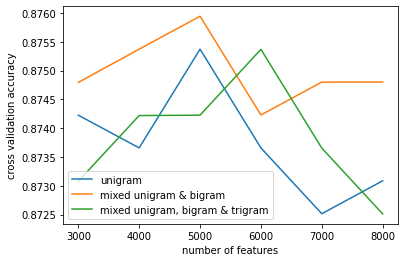

In [ ]:
plot_ngram_num_features(SVC(random_state = 0))

#### RBF-SVM Best Model

In [ ]:
vectorizer = TfidfVectorizer(max_features=5000, stop_words = text.ENGLISH_STOP_WORDS,lowercase=True, ngram_range=(1,2), binary=True)
vec_X_train = np.asarray(vectorizer.fit_transform(X_train).todense())

clf = SVC(random_state = 0)
cv_results = cross_validate(clf, vec_X_train, encoded_y_train, cv=10, return_train_score=True)

print("cross validated training accuracy: " + str(cv_results['train_score'].mean()))
print("cross validated validation accuracy: " + str(cv_results['test_score'].mean()))

In [ ]:
clf = SVC(random_state = 0) #0.003727593720314938
cv_results = cross_validate(clf, vec_X_train, encoded_y_train, cv=10, return_train_score=True)
print("cross validated training accuracy: " + str(cv_results['train_score'].mean()))
print("cross validated validation accuracy: " + str(cv_results['test_score'].mean()))

cross validated training accuracy: 0.9662031019947157
cross validated validation accuracy: 0.8370410509031199


### Logistic Regression

#### LR Feature Size vs Ngram

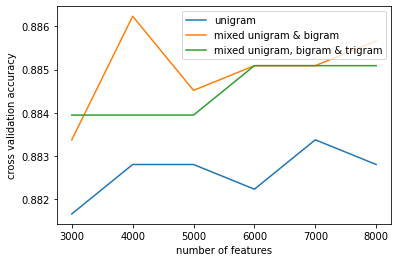

In [ ]:
plot_ngram_num_features(LogisticRegression(random_state = 0))

#### LR Hyperparameter Tuning

In [ ]:
bin_vectorizer = TfidfVectorizer(max_features=4000, stop_words = text.ENGLISH_STOP_WORDS,lowercase=True, ngram_range=(1,2), binary=True)
non_bin_vectorizer = TfidfVectorizer(max_features=4000, stop_words = text.ENGLISH_STOP_WORDS,lowercase=True, ngram_range=(1,2), binary=False)

bin_vec_X_train = np.asarray(bin_vectorizer.fit_transform(X_train).todense())
non_bin_vec_X_train = np.asarray(non_bin_vectorizer.fit_transform(X_train).todense())

Binary vectorizer:
max C:1.0 validation accuracy:0.8902430213464697
Non-Binary vectorizer
max C:0.7543120063354615 validation accuracy:0.8862331691297209


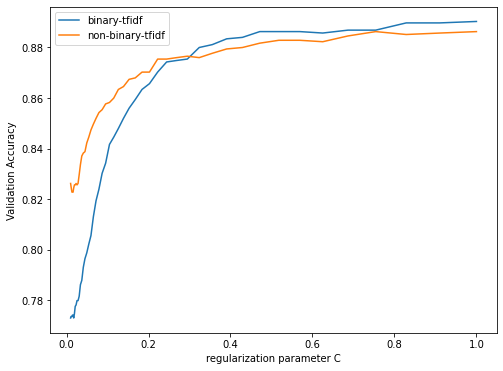

In [ ]:
plt.style.use('default')
plt.figure(figsize=(8,6))

C_list = np.logspace(-2,0)
tuned_parameters = [{'C':C_list}]

clf = LogisticRegression(random_state = 0)

LR_grid_binary = GridSearchCV(clf,tuned_parameters,cv = 10, return_train_score = True)
LR_grid_binary.fit(bin_vec_X_train, encoded_y_train)
LR_grid_non_binary = GridSearchCV(clf,tuned_parameters,cv = 10, return_train_score = True)
LR_grid_non_binary.fit(non_bin_vec_X_train, encoded_y_train)

LR_grid_train_scores_binary = LR_grid_binary.cv_results_['mean_train_score']
LR_grid_train_scores_non_binary = LR_grid_non_binary.cv_results_['mean_train_score']

LR_grid_test_scores_binary = LR_grid_binary.cv_results_['mean_test_score']
LR_grid_test_scores_non_binary = LR_grid_non_binary.cv_results_['mean_test_score']

plt1 = plt.plot(C_list,LR_grid_train_scores_binary)
plt2 = plt.plot(C_list,LR_grid_test_scores_binary)
plt3 = plt.plot(C_list,LR_grid_train_scores_non_binary)
plt4 = plt.plot(C_list,LR_grid_test_scores_non_binary)

plt.xlabel('regularization parameter C')
plt.ylabel('Accuracy')
plt.legend(['binary-tfidf training','binary-tfidf validation','non-binary-tfidf training', 'non-binary-tfidf validation'])

print("Binary vectorizer:")
print('max C:' + str(C_list[np.argmax(LR_grid_test_scores_binary)]) + " validation accuracy:" + str(LR_grid_test_scores_binary.max()))
print("Non-Binary vectorizer")
print('max C:' + str(C_list[np.argmax(LR_grid_test_scores_non_binary)]) + " validation accuracy:" + str(LR_grid_test_scores_non_binary.max()))

#### LR Best Model

In [ ]:
vectorizer = TfidfVectorizer(max_features=4000, stop_words = text.ENGLISH_STOP_WORDS,lowercase=True, ngram_range=(1,2), binary=True)
vec_X_train = np.asarray(vectorizer.fit_transform(X_train).todense())

clf = LogisticRegression(random_state = 0, C=1)
start = time()
cv_results = cross_validate(clf, vec_X_train, encoded_y_train, cv=10, return_train_score=True)
end = time()

print("cross validated training accuracy: " + str(cv_results['train_score'].mean()))
print("cross validated validation accuracy: " + str(cv_results['test_score'].mean()))

cross validated training accuracy: 0.9885648131340634
cross validated validation accuracy: 0.8902430213464697


In [ ]:
train_acc_results.append(cv_results['train_score'].mean())
test_acc_results.append(cv_results['test_score'].mean())
run_time.append(end-start)

### Random Forest

#### Random Forest Feature Size vs Ngram

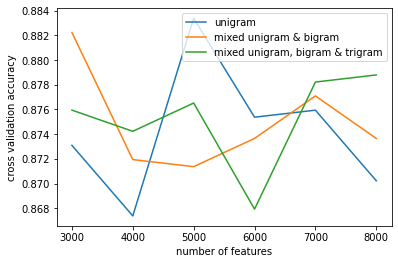

In [ ]:
plot_ngram_num_features(RandomForestClassifier(random_state=0))

#### Random Forest Hyperparameter Tuning

In [ ]:
bin_vectorizer = TfidfVectorizer(max_features=5000, stop_words = text.ENGLISH_STOP_WORDS,lowercase=True, ngram_range=(1,1), binary=True)
non_bin_vectorizer = TfidfVectorizer(max_features=5000, stop_words = text.ENGLISH_STOP_WORDS,lowercase=True, ngram_range=(1,1), binary=False)

bin_vec_X_train = np.asarray(bin_vectorizer.fit_transform(X_train).todense())
non_bin_vec_X_train = np.asarray(non_bin_vectorizer.fit_transform(X_train).todense())

Binary vectorizer:
max k:85 validation accuracy:0.878791461412151
Non-Binary vectorizer
max k:45 validation accuracy:0.8845221674876849


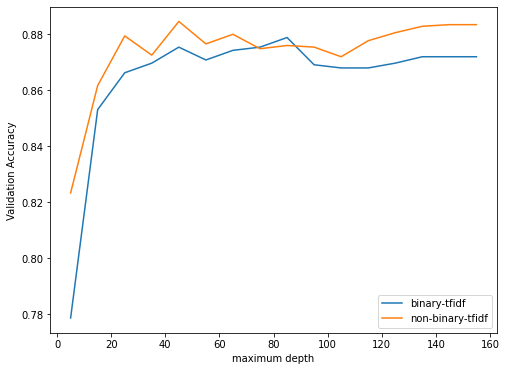

In [ ]:
plt.style.use('default')
plt.figure(figsize=(8,6))

max_depth_list = range(5,156,10)
tuned_parameters = [{'max_depth':max_depth_list}]

clf = RandomForestClassifier(random_state=0)

RF_grid_binary = GridSearchCV(clf,tuned_parameters,cv = 10, return_train_score = True)
RF_grid_binary.fit(bin_vec_X_train, encoded_y_train)
RF_grid_non_binary = GridSearchCV(clf,tuned_parameters,cv = 10, return_train_score = True)
RF_grid_non_binary.fit(non_bin_vec_X_train, encoded_y_train)

RF_grid_train_scores_binary = RF_grid_binary.cv_results_['mean_train_score']
RF_grid_train_scores_non_binary = RF_grid_non_binary.cv_results_['mean_train_score']
RF_grid_test_scores_binary = RF_grid_binary.cv_results_['mean_test_score']
RF_grid_test_scores_non_binary = RF_grid_non_binary.cv_results_['mean_test_score']

plt1 = plt.plot(max_depth_list,RF_grid_train_scores_binary)
plt1 = plt.plot(max_depth_list,RF_grid_test_scores_binary)
plt2 = plt.plot(max_depth_list,RF_grid_train_scores_non_binary)
plt2 = plt.plot(max_depth_list,RF_grid_test_scores_non_binary)

plt.xlabel('maximum depth')
plt.ylabel('Validation Accuracy')
plt.legend(['binary-tfidf training','binary-tfidf validation','non-binary-tfidf training', 'non-binary-tfidf validation'])

print("Binary vectorizer:")
print('max k:' + str(max_depth_list[np.argmax(RF_grid_test_scores_binary)]) + " validation accuracy:" + str(RF_grid_test_scores_binary.max()))
print("Non-Binary vectorizer")
print('max k:' + str(max_depth_list[np.argmax(RF_grid_test_scores_non_binary)]) + " validation accuracy:" + str(RF_grid_test_scores_non_binary.max()))

#### Random Forest Best Model

In [ ]:
vectorizer = TfidfVectorizer(max_features=5000, stop_words = text.ENGLISH_STOP_WORDS,lowercase=True, ngram_range=(1,1), binary=False)
vec_X_train = np.asarray(vectorizer.fit_transform(X_train).todense())

clf = RandomForestClassifier(random_state=0, max_depth=45)
start = time()
cv_results = cross_validate(clf, vec_X_train, encoded_y_train, cv=10, return_train_score=True)
end = time()

print("cross validated training accuracy: " + str(cv_results['train_score'].mean()))
print("cross validated validation accuracy: " + str(cv_results['test_score'].mean()))

In [ ]:
train_acc_results.append(cv_results['train_score'].mean())
test_acc_results.append(cv_results['test_score'].mean())
run_time.append(end-start)

### Ensemble Stacking 

In [92]:
vectorizer = TfidfVectorizer(max_features=5000, stop_words=lemmatized_stop_words,lowercase=True, ngram_range=(1,1), binary=True, tokenizer=LemmaTokenizer())
vec_X_train = np.asarray(vectorizer.fit_transform(X_train).todense())
vec_X_test = np.asarray(vectorizer.transform(X_test).todense())

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['le'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [ ]:
# clf1 = LogisticRegression(random_state = 0, C=1)
# clf2 = LinearSVC(random_state = 0, C = 0.517947467923121)
# clf3 = RandomForestClassifier(random_state=0, max_depth=45)

# eclf1 = VotingClassifier(estimators=[
#         ('lr', clf1), ('svm', clf2), ('mnb', clf3)], voting='hard')

In [93]:
clf1 = LogisticRegression(random_state = 0, C=1)
clf2 = LinearSVC(random_state = 0, C = 0.517947467923121)
clf3 = RandomForestClassifier(random_state=0, max_depth=45)

eclf1 = StackingClassifier(estimators=[
        ('lr', clf1), ('svm', clf2), ('rf', clf3)])

In [94]:
start = time()
cv_results = cross_validate(eclf1, vec_X_train, encoded_y_train, cv=10, return_train_score=True)
end = time()

print("cross validated training accuracy: " + str(cv_results['train_score'].mean()))
print("cross validated validation accuracy: " + str(cv_results['test_score'].mean()))

cross validated training accuracy: 0.9988564974486194
cross validated validation accuracy: 0.8828078817733991


In [ ]:
train_acc_results.append(cv_results['train_score'].mean())
test_acc_results.append(cv_results['test_score'].mean())
run_time.append(end-start)

In [ ]:
eclf1.fit(vec_X_train, encoded_y_train)
index_array = eclf1.predict(vec_X_test)

## Experimentations on Best Model

In [ ]:
vectorizer = TfidfVectorizer(max_features=6000, stop_words = text.ENGLISH_STOP_WORDS,lowercase=True, ngram_range=(1,1), binary=True)
vec_X_train = np.asarray(vectorizer.fit_transform(X_train).todense())
vec_X_test = np.asarray(vectorizer.transform(X_test).todense())

clf = LinearSVC(random_state=0, C = 0.517947467923121)
cv_results = cross_validate(clf, vec_X_train, encoded_y_train, cv=10, return_train_score=True)

print("cross validated training accuracy: " + str(cv_results['train_score'].mean()))
print("cross validated validation accuracy: " + str(cv_results['test_score'].mean()))

cross validated training accuracy: 0.9986658599060123
cross validated validation accuracy: 0.9005221674876847


In [ ]:
clf.fit(vec_X_train, encoded_y_train)
prediction = clf.predict(vec_X_test)

In [ ]:
download_csv(index_array)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
svm = LinearSVC(random_state=0, C = 0.517947467923121)
clf = BaggingClassifier(base_estimator=svm, n_estimators=23, random_state=0)

cv_results = cross_validate(clf, vec_X_train, encoded_y_train, cv=10, return_train_score=True)

print("cross validated training accuracy: " + str(cv_results['train_score'].mean()))
print("cross validated validation accuracy: " + str(cv_results['test_score'].mean()))

cross validated training accuracy: 0.9955529739214619
cross validated validation accuracy: 0.8896683087027915


In [ ]:
clf.fit(vec_X_train, encoded_y_train)
index_array = clf.predict(vec_X_test)

##Bar chart

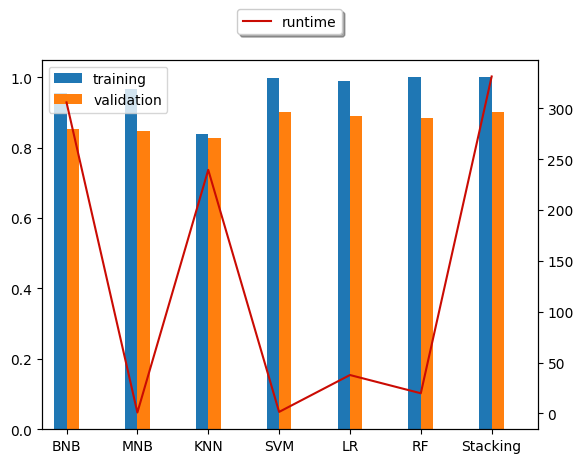

In [75]:
plt.style.use('default')
train_acc_results=[0.9554668118835844,
  0.9652499546197133,
  0.8392735927068836,
  0.9986658599060123,
  0.9885648131340634,
  0.9994917407878017,
  0.9998729351969505
]
test_acc_results=[0.8536453201970442,
  0.8467750410509032,
  0.8261937602627258,
  0.9005221674876847,
  0.8902430213464697,
  0.8845221674876849,
  0.9005287356321838]
run_time=[305.90363335609436,
 0.9395320415496826,
 239.54530572891235,
 1.4930760860443115,
 37.7825870513916,
 19.823238849639893,
 331.39533829689026]

m1_t = pd.DataFrame({
 'training' : train_acc_results,
 'validation' : test_acc_results,
 'runtime' : run_time})

m1_t[['training','validation']].plot(kind='bar', width = 0.35)
m1_t['runtime'].plot(secondary_y=True, color='r')


ax = plt.gca()

plt.xlim([-0.35, len(m1_t['validation'])-0.35])
ax.set_xticklabels(('BNB','MNB', 'KNN', 'SVM', 'LR', 'RF','Stacking'))
ax.set_xlabel('model')
ax.legend(loc='lower center', bbox_to_anchor=(0.5, 1.05),
          ncol=3, fancybox=True, shadow=True)
plt.show()